# Assignment 01: Multi-class Classification with Different Loss Functions


## 1. Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### 1.1 Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### 1.2 Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### 1.3 Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170498071/170498071 [00:14<00:00, 11412723.14it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


## 2. Model

## 2.1 Define the Neural Network

In [5]:
## this is the model for Cross Entropy, since nn.crossentropy is equipped with a softmax layer, here we do not employ a softmax layer
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
## define a model which has a softmax layer as the last layer, which is significant when considering L1 Loss and Focal Loss

class ConvNet_DIY(nn.Module):
    def __init__(self):
        super(ConvNet_DIY, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = nn.Softmax(dim=1)(x) 
        return x

### 2.2 Define the Loss Functions and train_batch, testing_batch

In [7]:
# Define Focal Loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        
        eps = 1e-6
        probs = inputs.clamp(eps, 1. - eps)
        
        # calculate the loss of each class
        class_loss = -targets * torch.log(probs) * self.alpha * (1 - probs)**self.gamma
        
        # sum up
        loss = class_loss.sum(dim=1)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [8]:
##################### Define the 4 required Loss Functions##################
CrossEntropy = nn.CrossEntropyLoss()
L1Loss = nn.L1Loss()
FocalLoss_05 = FocalLoss(gamma=0.5)
FocalLoss_2 = FocalLoss(gamma=2)
###############################################################

In [9]:
def train_batch(model, image, target, loss_fn):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.
        loss_fn (torch.nn.Module, optional): Loss function to compute the loss.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function.
    """
    
    output = model(image) 
    loss = loss_fn(output, target)

    return output, loss

In [10]:
def test_batch(model, image, target, loss_fn):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image) 
    loss = loss_fn(output, target)
    ###############################################################

    return output, loss

## 3.  Model Training with Different Loss Functions

### 3.1 CrossEntropy

In [11]:
## initial the model for Cross Entropy

model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [12]:
training_loss_CE = []
training_acc_CE = []
testing_loss_CE = []
testing_acc_CE = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target, CrossEntropy)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_CE.append(epoch_loss)
    training_acc_CE.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target, CrossEntropy)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_CE.append(val_loss)
        testing_acc_CE.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_CE = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_CE, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0152 Acc: 0.2683
Begin test......
Test Loss: 0.0138 Acc: 0.3391
Epoch: 2/30 Train Loss: 0.0142 Acc: 0.3246
Begin test......
Test Loss: 0.0136 Acc: 0.3640
Epoch: 3/30 Train Loss: 0.0138 Acc: 0.3523
Begin test......
Test Loss: 0.0129 Acc: 0.4076
Epoch: 4/30 Train Loss: 0.0135 Acc: 0.3679
Begin test......
Test Loss: 0.0131 Acc: 0.3950
Epoch: 5/30 Train Loss: 0.0135 Acc: 0.3719
Begin test......
Test Loss: 0.0133 Acc: 0.3791
Epoch: 6/30 Train Loss: 0.0126 Acc: 0.4167
Begin test......
Test Loss: 0.0117 Acc: 0.4640
Epoch: 7/30 Train Loss: 0.0123 Acc: 0.4332
Begin test......
Test Loss: 0.0115 Acc: 0.4688
Epoch: 8/30 Train Loss: 0.0121 Acc: 0.4392
Begin test......
Test Loss: 0.0112 Acc: 0.4913
Epoch: 9/30 Train Loss: 0.0120 Acc: 0.4453
Begin test......
Test Loss: 0.0115 Acc: 0.4770
Epoch: 10/30 Train Loss: 0.0120 Acc: 0.4453
Begin test......
Test Loss: 0.0116 Acc: 0.4749
Epoch: 11/30 Train Loss: 0.0114 Acc: 0.4752
Begin test......
Test Loss: 0.0109 Acc: 0.5060
Epoch: 1

### 3.2 L1Loss

In [13]:
## initial the model for L1 Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [14]:
## to adjust "target" to one-hot vector

def to_one_hot(targets, num_classes):
    one_hot = torch.zeros(targets.size(0), num_classes).to(targets.device)
    one_hot.scatter_(1, targets.unsqueeze(1), 1.)
    return one_hot

In [15]:
training_loss_L1 = []
training_acc_L1 = []
testing_loss_L1 = []
testing_acc_L1 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, L1Loss)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_L1.append(epoch_loss)
    training_acc_L1.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, L1Loss)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_L1.append(val_loss)
        testing_acc_L1.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_L1 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_L1, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0013 Acc: 0.1790
Begin test......
Test Loss: 0.0012 Acc: 0.2603
Epoch: 2/30 Train Loss: 0.0011 Acc: 0.2700
Begin test......
Test Loss: 0.0011 Acc: 0.3128
Epoch: 3/30 Train Loss: 0.0011 Acc: 0.2945
Begin test......
Test Loss: 0.0010 Acc: 0.3418
Epoch: 4/30 Train Loss: 0.0011 Acc: 0.3134
Begin test......
Test Loss: 0.0010 Acc: 0.3555
Epoch: 5/30 Train Loss: 0.0011 Acc: 0.3289
Begin test......
Test Loss: 0.0010 Acc: 0.3516
Epoch: 6/30 Train Loss: 0.0010 Acc: 0.3457
Begin test......
Test Loss: 0.0010 Acc: 0.3771
Epoch: 7/30 Train Loss: 0.0010 Acc: 0.3542
Begin test......
Test Loss: 0.0010 Acc: 0.3882
Epoch: 8/30 Train Loss: 0.0010 Acc: 0.3569
Begin test......
Test Loss: 0.0010 Acc: 0.3808
Epoch: 9/30 Train Loss: 0.0010 Acc: 0.3596
Begin test......
Test Loss: 0.0010 Acc: 0.3861
Epoch: 10/30 Train Loss: 0.0010 Acc: 0.3626
Begin test......
Test Loss: 0.0009 Acc: 0.4056
Epoch: 11/30 Train Loss: 0.0010 Acc: 0.3711
Begin test......
Test Loss: 0.0009 Acc: 0.4054
Epoch: 1

### 3.3 Focal Loss with $\gamma$ = 2

In [16]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [17]:
training_loss_Focal2 = []
training_acc_Focal2 = []
testing_loss_Focal2 = []
testing_acc_Focal2 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_2)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal2.append(epoch_loss)
    training_acc_Focal2.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_2)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal2.append(val_loss)
        testing_acc_Focal2.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal2 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal2, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0115 Acc: 0.2679
Begin test......
Test Loss: 0.0088 Acc: 0.4015
Epoch: 2/30 Train Loss: 0.0089 Acc: 0.3927
Begin test......
Test Loss: 0.0082 Acc: 0.4330
Epoch: 3/30 Train Loss: 0.0083 Acc: 0.4259
Begin test......
Test Loss: 0.0077 Acc: 0.4594
Epoch: 4/30 Train Loss: 0.0080 Acc: 0.4454
Begin test......
Test Loss: 0.0071 Acc: 0.5019
Epoch: 5/30 Train Loss: 0.0077 Acc: 0.4607
Begin test......
Test Loss: 0.0070 Acc: 0.4985
Epoch: 6/30 Train Loss: 0.0073 Acc: 0.4849
Begin test......
Test Loss: 0.0071 Acc: 0.5092
Epoch: 7/30 Train Loss: 0.0072 Acc: 0.4893
Begin test......
Test Loss: 0.0067 Acc: 0.5252
Epoch: 8/30 Train Loss: 0.0071 Acc: 0.4985
Begin test......
Test Loss: 0.0065 Acc: 0.5342
Epoch: 9/30 Train Loss: 0.0071 Acc: 0.4983
Begin test......
Test Loss: 0.0064 Acc: 0.5450
Epoch: 10/30 Train Loss: 0.0070 Acc: 0.5030
Begin test......
Test Loss: 0.0064 Acc: 0.5468
Epoch: 11/30 Train Loss: 0.0068 Acc: 0.5131
Begin test......
Test Loss: 0.0063 Acc: 0.5589
Epoch: 1

### 3.4 Focal Loss with $\gamma = 0.5$

In [18]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [19]:
training_loss_Focal05 = []
training_acc_Focal05 = []
testing_loss_Focal05 = []
testing_acc_Focal05 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_05)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal05.append(epoch_loss)
    training_acc_Focal05.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_05)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal05.append(val_loss)
        testing_acc_Focal05.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal05 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal05, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0146 Acc: 0.2598
Begin test......
Test Loss: 0.0119 Acc: 0.3867
Epoch: 2/30 Train Loss: 0.0119 Acc: 0.3779
Begin test......
Test Loss: 0.0106 Acc: 0.4464
Epoch: 3/30 Train Loss: 0.0113 Acc: 0.4191
Begin test......
Test Loss: 0.0101 Acc: 0.4857
Epoch: 4/30 Train Loss: 0.0106 Acc: 0.4489
Begin test......
Test Loss: 0.0097 Acc: 0.5028
Epoch: 5/30 Train Loss: 0.0103 Acc: 0.4676
Begin test......
Test Loss: 0.0093 Acc: 0.5206
Epoch: 6/30 Train Loss: 0.0098 Acc: 0.4904
Begin test......
Test Loss: 0.0092 Acc: 0.5216
Epoch: 7/30 Train Loss: 0.0098 Acc: 0.4959
Begin test......
Test Loss: 0.0090 Acc: 0.5379
Epoch: 8/30 Train Loss: 0.0096 Acc: 0.5002
Begin test......
Test Loss: 0.0092 Acc: 0.5354
Epoch: 9/30 Train Loss: 0.0096 Acc: 0.5059
Begin test......
Test Loss: 0.0089 Acc: 0.5408
Epoch: 10/30 Train Loss: 0.0096 Acc: 0.5034
Begin test......
Test Loss: 0.0087 Acc: 0.5482
Epoch: 11/30 Train Loss: 0.0093 Acc: 0.5174
Begin test......
Test Loss: 0.0086 Acc: 0.5612
Epoch: 1

## 4. Draw the pictures to compare the results

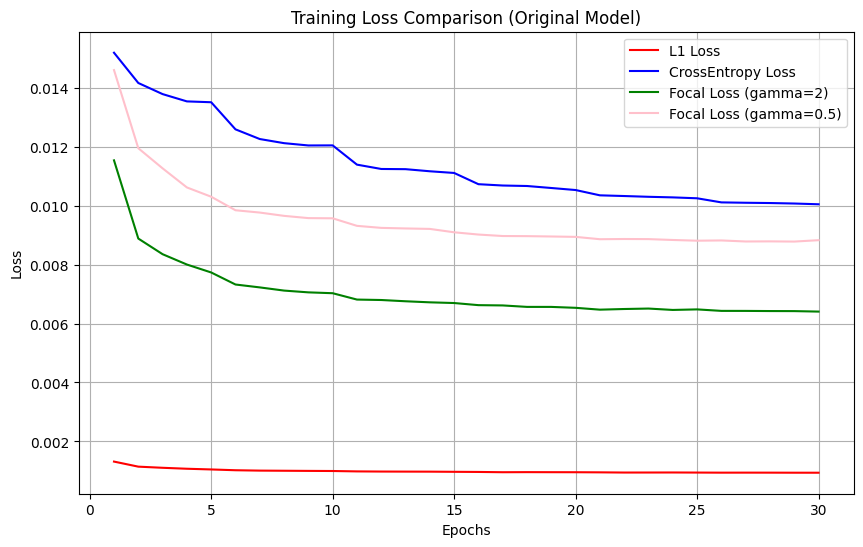

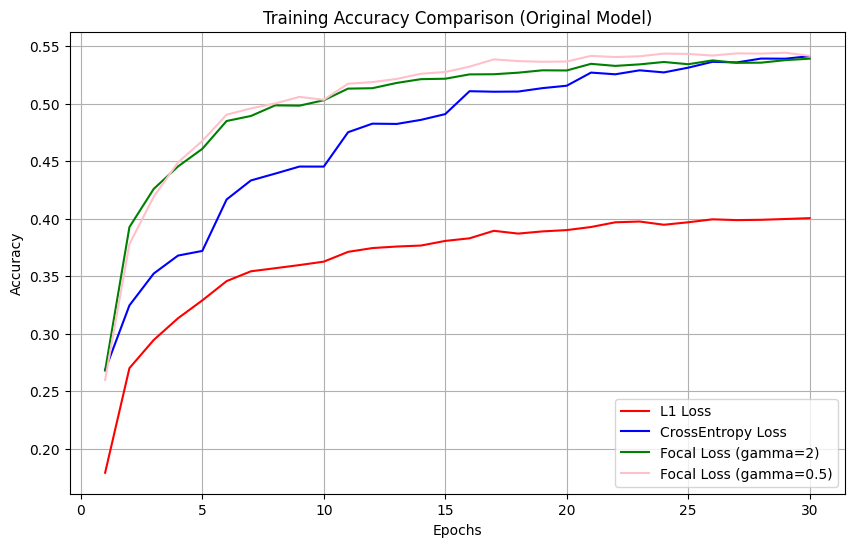

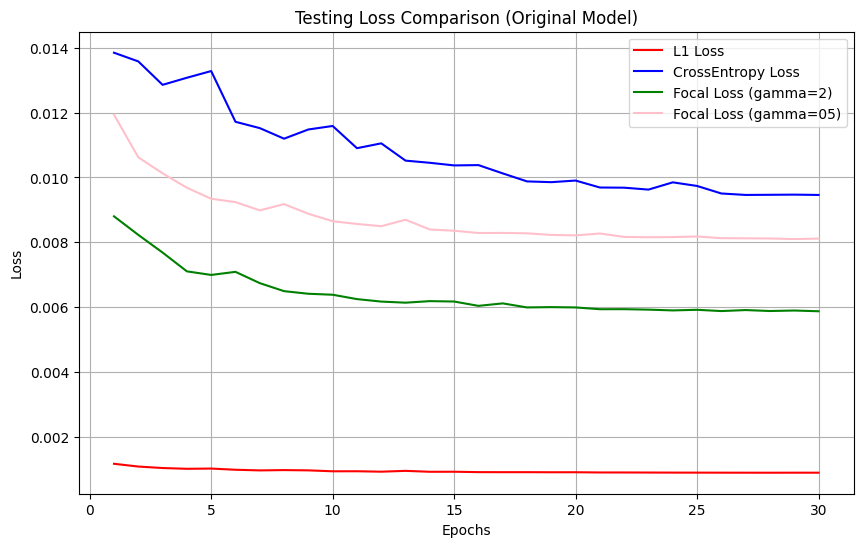

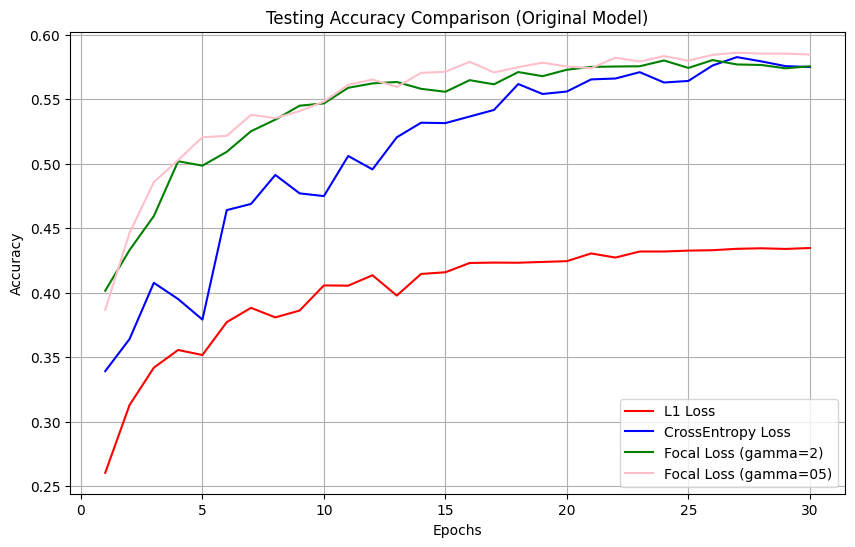

In [21]:
epochs = range(1, len(training_loss_L1) + 1)

# 训练损失对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_L1, label='L1 Loss', color='red')
plt.plot(epochs, training_loss_CE, label='CrossEntropy Loss', color='blue')
plt.plot(epochs, training_loss_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, training_loss_Focal05, label='Focal Loss (gamma=0.5)', color='pink')
plt.title('Training Loss Comparison (Original Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('pic/training_loss_comparison.png')
plt.show()

# 训练准确率对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_L1, label='L1 Loss', color='red')
plt.plot(epochs, training_acc_CE, label='CrossEntropy Loss', color='blue')
plt.plot(epochs, training_acc_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, training_acc_Focal05, label='Focal Loss (gamma=0.5)', color='pink')
plt.title('Training Accuracy Comparison (Original Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('pic/training_accuracy_comparison.png')
plt.show()

# 测试损失对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, testing_loss_L1, label='L1 Loss', color='red')
plt.plot(epochs, testing_loss_CE, label='CrossEntropy Loss', color='blue')
plt.plot(epochs, testing_loss_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, testing_loss_Focal05, label='Focal Loss (gamma=05)', color='pink')
plt.title('Testing Loss Comparison (Original Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('pic/testing_loss_comparison.png')
plt.show()

# 测试准确率对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, testing_acc_L1, label='L1 Loss', color='red')
plt.plot(epochs, testing_acc_CE, label='CrossEntropy Loss', color='blue')
plt.plot(epochs, testing_acc_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, testing_acc_Focal05, label='Focal Loss (gamma=05)', color='pink')
plt.title('Testing Accuracy Comparison (Original Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('pic/testing_accuracy_comparison.png')
plt.show()